# LeNet5
[블로그](https://gjustin40.github.io/classification/2020/12/30/Model-LeNet5.html)에서 이론 확인하기

## 요약
- MNSIT Dataset 이용
- Convoultional Layer 2개
- Fully-connected Layer 3개
- Average Pooling Layer 2개
- Activation Function(활성화 함수) : Tanh
- 출력값 Softmax 사용
- 데이터 6만개(MNIST)
- Cost Function(손실함수) : Cross-Entropy

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

### Datasets

In [2]:
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../../data', train=False, download=True, transform=transform)

train_dataset, val_dataset = random_split(train_dataset, (55000, 5000))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Visualization

In [3]:
def show_image(x, y, y_pred=None):
    
    x = x[:9, 0, ...]
    y = y[:9]
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        ax.imshow(x[i], cmap='gray')
        
        if y_pred is None:
            xlabel = "True: {}".format(y[i])
        else:
            xlabel = "True: {}, Pred: {}".format(y[i], y_pred[i])
            
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

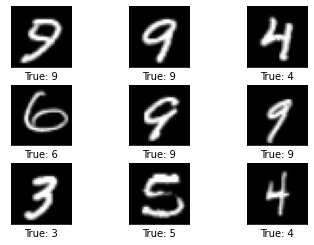

In [4]:
images, labels = iter(train_loader).next()
show_image(images, labels)

### Model

![LeNet-5 Architecture](lenet5-arch.PNG)

In [5]:
class Lenet5(nn.Module):
    
    def __init__(self):
        super(Lenet5, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.avgpool = nn.AvgPool2d(2,2)
        
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
       
        x = torch.tanh(self.conv1(x))
        x = self.avgpool(x)
        
        x = torch.tanh(self.conv2(x))
        x = self.avgpool(x)
        
        x = x.view(-1, 16*5*5)
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        
        return x
                

In [6]:
model = Lenet5()
model

Lenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Optimizer & Loss Function

In [7]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

### Cuda

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Training

In [9]:
EPOCH = 20
train_loss_list, val_loss_list = [], []

for e in range(EPOCH):
    
    train_loss = 0
    train_correct = 0
    
    model.to(device)
    model.train()
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)
        loss = loss_func(output, labels)
        loss.backward()
        train_loss += loss.cpu().item()
        
        optimizer.step()
        
        pred = output.argmax(1)
        train_correct += (pred == labels).cpu().sum().item()
        
    train_acc = train_correct / len(train_dataset)
    train_loss = train_loss / len(train_dataset)
    train_loss_list.append(train_loss)
    
    val_loss = 0
    val_correct = 0
    
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            output = model(images)
            loss = loss_func(output, labels)
            val_loss += loss.cpu().item()
            
            val_pred = output.argmax(1)
            val_correct += (val_pred == labels).cpu().sum().item()
            
        val_acc = val_correct / len(val_dataset)
        val_loss = val_loss / len(val_dataset)
        val_loss_list.append(val_loss)
    
    info = '[EPOCH {}/{}] : train-loss = {:0.4f} | train-acc = {:0.4f} | val-loss = {:0.4f} | val-acc = {:0.4f}'
    print(info.format(e+1, EPOCH, train_loss, train_acc, val_loss, val_acc))
    
    torch.save(model.state_dict(), '../../data/weight')

[EPOCH 1/20] : train-loss = 0.1371 | train-acc = 0.3397 | val-loss = 0.1230 | val-acc = 0.6344
[EPOCH 2/20] : train-loss = 0.1057 | train-acc = 0.7445 | val-loss = 0.0940 | val-acc = 0.8016
[EPOCH 3/20] : train-loss = 0.0882 | train-acc = 0.8119 | val-loss = 0.0827 | val-acc = 0.8358
[EPOCH 4/20] : train-loss = 0.0801 | train-acc = 0.8370 | val-loss = 0.0766 | val-acc = 0.8538
[EPOCH 5/20] : train-loss = 0.0754 | train-acc = 0.8490 | val-loss = 0.0730 | val-acc = 0.8664
[EPOCH 6/20] : train-loss = 0.0724 | train-acc = 0.8593 | val-loss = 0.0705 | val-acc = 0.8710
[EPOCH 7/20] : train-loss = 0.0703 | train-acc = 0.8665 | val-loss = 0.0686 | val-acc = 0.8790
[EPOCH 8/20] : train-loss = 0.0686 | train-acc = 0.8752 | val-loss = 0.0671 | val-acc = 0.8868
[EPOCH 9/20] : train-loss = 0.0673 | train-acc = 0.8850 | val-loss = 0.0659 | val-acc = 0.8922
[EPOCH 10/20] : train-loss = 0.0661 | train-acc = 0.8947 | val-loss = 0.0649 | val-acc = 0.9050
[EPOCH 11/20] : train-loss = 0.0650 | train-acc =

### Test

Accuracy of Test Data : 93.84%


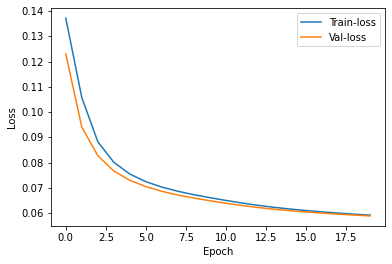

In [10]:
model.cpu()
model.eval()

test_correct = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        
        prediction = model(images)
        test_correct += (prediction.argmax(1) == labels).sum().item()
        
    test_acc = test_correct / len(test_dataset)
    print('Accuracy of Test Data : %0.2f%%' %(test_acc*100))

plt.plot(train_loss_list)
plt.plot(val_loss_list)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train-loss', 'Val-loss'])

plt.show()